In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
cities = ['ABZ', 'ALE', 'AMA', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'DEL', 'EGB',
          'FKL', 'HAD', 'HEL', 'HPB', 'HRW', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 
          'MLP', 'MUK', 'NAN', 'NEU', 'POV', 'SAO', 'SCH', 'SGP', 'UAE', # 'PRL',
          'VAR', 'VHL', 'VIE', 'WAL', 'ZOT']

variables = ['aermr_seasalt', 'aermr01', 'aermr02', 'aermr03', 
             'aermr_dust', 'aermr04', 'aermr05', 'aermr06',
             'aermr_hphi', 'aermr_hpho', 'aermr_om', 'aermr_ombc', 'aermr_bc', 
             'aermr07', 'aermr08', 'aermr09', 'aermr10', 
             'co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2', 'd2m', 't2m', 
             'crwc', 'blh', 'rh', 'doy_sin', 'doy_cos', 'latitude', 'longitude_sin', 'longitude_cos']

dont_transform = ['d2m', 't2m', 'blh', 'rh', 'doy_sin', 'doy_cos', 'latitude', 'longitude_sin', 'longitude_cos']
transf_vars = []
for v in variables:    
    if v in dont_transform:
        transf_vars.append(v)
    else:
        transf_vars.append(v+'_log')

In [27]:
# loading the data
data = pd.read_csv('data/full_data.csv', parse_dates=['date'])

# log-transformed values that are < 1 become negative, which doesn't make sense
data.loc[data.n100 < 1, 'n100'] = 1

# adding variables that aggregate the mixing ratios for the same type of aerosol
data['aermr_seasalt'] = data['aermr01'] + data['aermr02'] + data['aermr03']
data['aermr_dust'] = data['aermr04'] + data['aermr05'] + data['aermr06']
data['aermr_om'] = data['aermr07'] + data['aermr08']
data['aermr_bc'] = data['aermr09'] + data['aermr10']
data['aermr_hphi'] = data['aermr07'] + data['aermr09']
data['aermr_hpho'] = data['aermr08'] + data['aermr10']
data['aermr_ombc'] = data['aermr07'] + data['aermr08'] + data['aermr09'] + data['aermr10']

# log-transforming selected variables
for v in ['n100']+variables:
    if v not in dont_transform:
        transformed = data[v]
        transformed = transformed.where(transformed > 0, transformed[transformed > 0].min())
        data[v+'_log'] = np.log(transformed)
        
data.head()

,id,station,date,doy_sin,doy_cos,latitude,longitude_sin,longitude_cos,n100,aermr01,...,aermr09_log,aermr10_log,co_log,c5h8_log,c10h16_log,nh3_log,no_log,no2_log,so2_log,crwc_log
0,ABZ-2012-01-26,ABZ,2012-01-26,0.431673,0.902030,0.561889,0.438057,0.898947,2708.085714,6.752697e-12,...,-22.383946,-21.309149,-14.888857,-24.715712,-22.277308,-20.891909,-18.156078,-17.697916,-18.856889,-24.916861
1,ABZ-2012-01-27,ABZ,2012-01-27,0.447094,0.894487,0.561889,0.438057,0.898947,2489.175000,4.223335e-12,...,-22.018130,-21.181645,-14.786466,-24.526129,-22.109902,-20.714570,-18.022533,-17.632291,-18.761336,-24.916861
2,ABZ-2012-01-28,ABZ,2012-01-28,0.462383,0.886680,0.561889,0.438057,0.898947,3484.229167,3.553853e-12,...,-21.523018,-20.943542,-14.472229,-24.080899,-21.518834,-20.381543,-17.223582,-17.785600,-18.708921,-24.916861
3,ABZ-2012-01-29,ABZ,2012-01-29,0.477536,0.878612,0.561889,0.438057,0.898947,2977.512500,8.665312e-12,...,-21.433621,-21.326093,-14.977114,-25.068593,-22.885339,-20.340459,-19.236020,-17.969860,-19.128033,-24.916861
4,ABZ-2012-01-30,ABZ,2012-01-30,0.492548,0.870285,0.561889,0.438057,0.898947,2702.463636,1.436837e-11,...,-21.482813,-21.669206,-15.236442,-25.461374,-23.836271,-20.333199,-20.702253,-18.124264,-19.070916,-24.916861


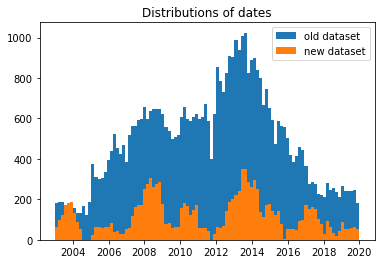

In [29]:
date_ranges = pd.read_csv('metadata/date_ranges_of_stations.csv', parse_dates=['start_date', 'end_date'], dayfirst=True)
date_ranges.head()

new_data = []

for c in cities:
    sd = date_ranges.start_date.loc[date_ranges.station == c].iloc[0]
    ed = date_ranges.end_date.loc[date_ranges.station == c].iloc[0]
    c_data = data.loc[data.station == c]
    c_data = c_data.loc[c_data.date >= sd]
    c_data = c_data.loc[c_data.date <= ed]
    new_data.append(c_data)

new_data = pd.concat(new_data)
new_data = new_data.reset_index(drop=True)

plt.hist(data.date, bins=100, label='old dataset')
plt.hist(new_data.date, bins=100, label='new dataset')
plt.title('Distributions of dates')
plt.legend()

data = new_data

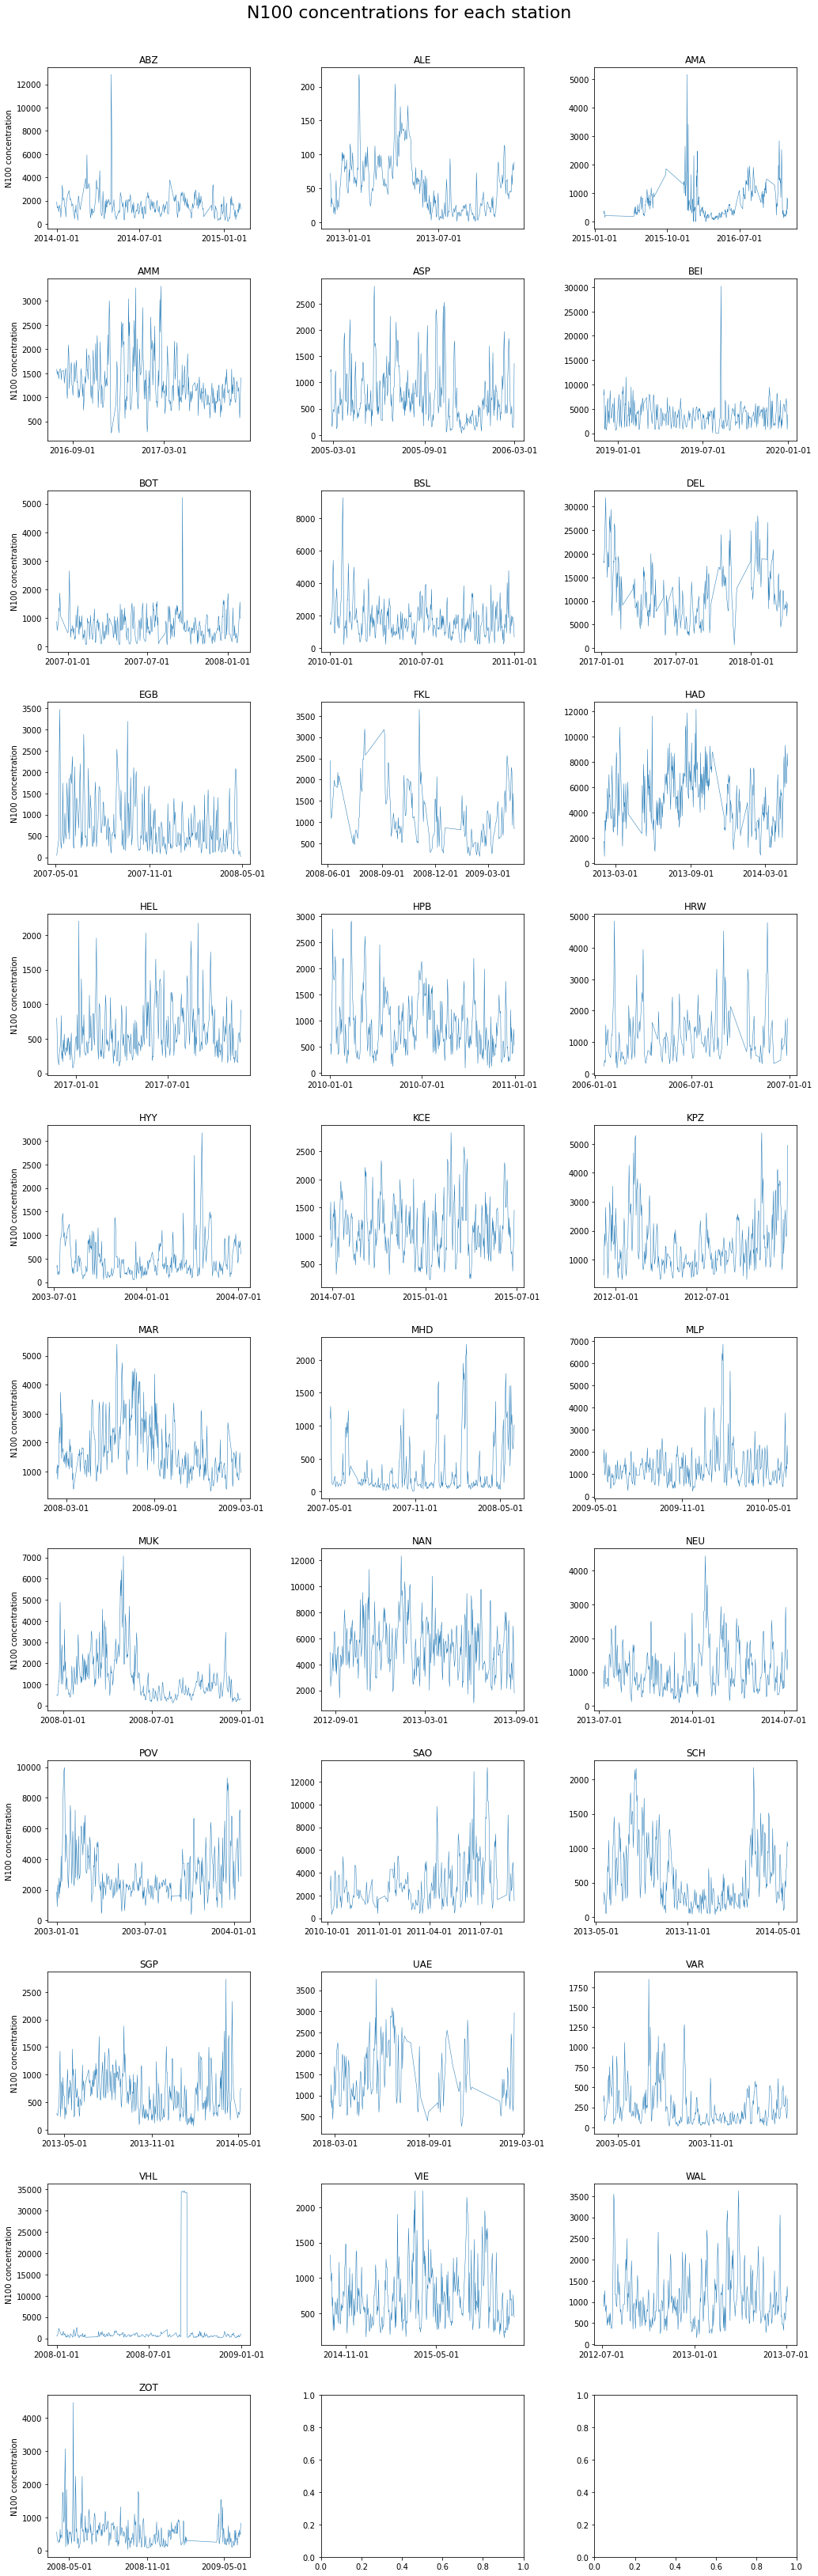

In [36]:
fig, axes = plt.subplots(12, 3, figsize=(15,45))
axes = iter(axes)
i = 0

for c in cities:
    if i%3 == 0:
        axis = next(axes)
    ax = axis[i%3]
    ax.plot(data.date.loc[data.station == c], data.n100.loc[data.station == c], lw=0.5)
    ax.set_title(c)
    ax.set_xticks(ax.get_xticks()[::3])
    if i%3 == 0:
        ax.set_ylabel('N100 concentration')
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('N100 concentrations for each station', y=1.01, fontsize=22);

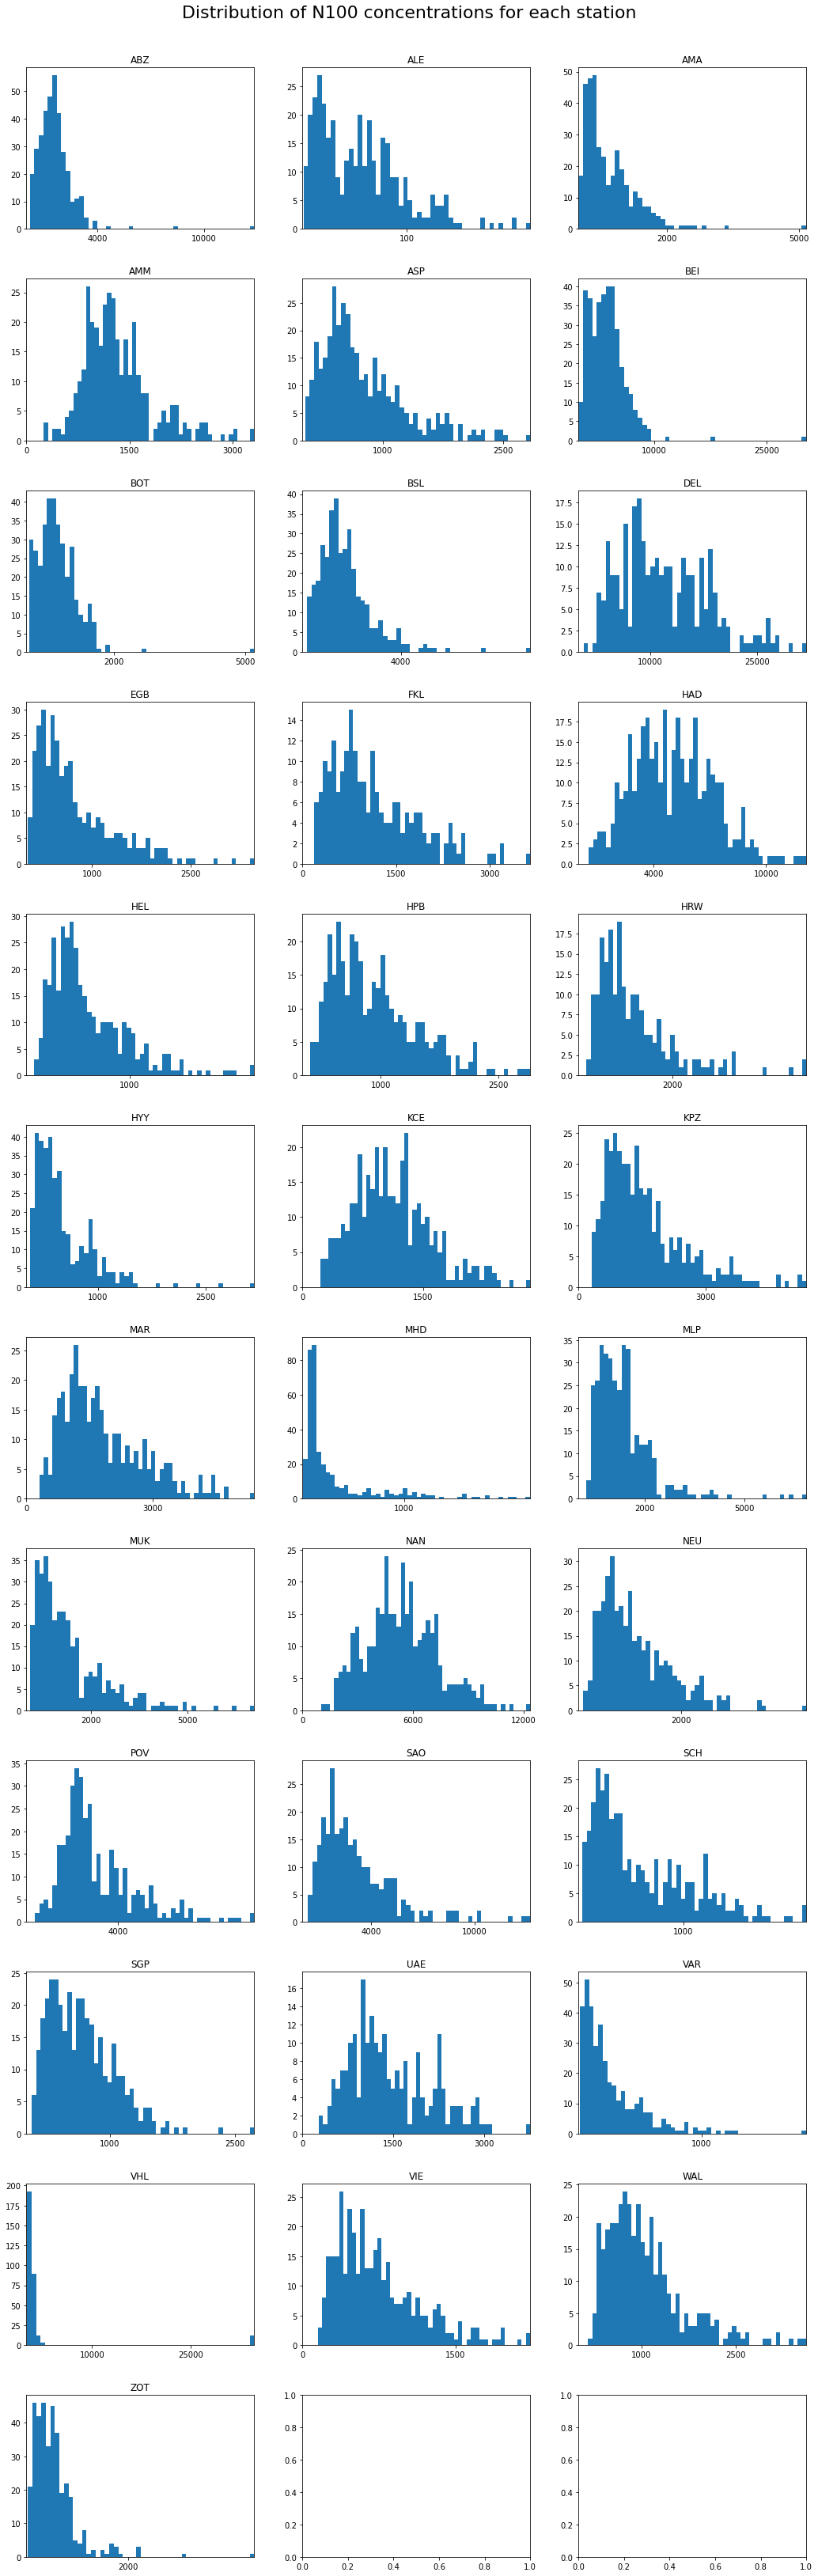

In [43]:
fig, axes = plt.subplots(12, 3, figsize=(15, 45))
axes = iter(axes)
i = 0

for c in cities:
    if i%3 == 0:
        axis = next(axes)
    ax = axis[i%3]
    ax.hist(data.n100.loc[data.station == c], bins=50)
    ax.set_title(c)
    ax.set_xticks(ax.get_xticks()[::3])
    ax.set_xlim(0, max(data.n100.loc[data.station == c]))
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('Distribution of N100 concentrations for each station', y=1.01, fontsize=22);

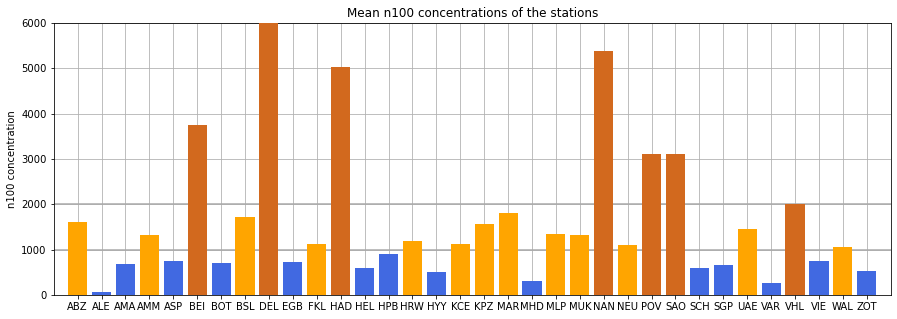

In [44]:
n100_means = []

for s, group in data.groupby('station'):
    n100_means.append(group.n100.mean())
    
n100_means_groups = np.where(np.array(n100_means) > 1000, 'medium', 'low')
n100_means_groups = np.where(np.array(n100_means) > 2000, 'high', n100_means_groups)

n100_means_colors = list(map(lambda x: {'high':'chocolate', 'medium':'orange', 'low':'royalblue'}[x], 
                             n100_means_groups))

plt.figure(figsize=(15,5))
plt.bar(cities, n100_means, zorder=3, color=n100_means_colors)
plt.grid(zorder=1)
plt.hlines([1000, 2000], xmin=-2, xmax=len(cities)+1, zorder=2, color='darkgrey')
plt.title('Mean n100 concentrations of the stations')
plt.ylabel('n100 concentration')
plt.ylim(0, 6000)
plt.xlim(-1, len(cities));

In [45]:
variable_dict = {'n100': 'N100 concentration',
                 'aermr_seasalt': 'Sea salt aerosol (0.03 - 20 µm)\nmixing ratio', 
                 'aermr01': 'Sea salt aerosol (0.03 - 0.5 µm)\nmixing ratio',
                 'aermr02': 'Sea salt aerosol (0.5 - 5 µm)\nmixing ratio',
                 'aermr03': 'Sea salt aerosol (5 - 20 µm)\nmixing ratio',
                 'aermr_dust': 'Dust aerosol (0.03 - 20 µm)\nmixing ratio', 
                 'aermr04': 'Dust aerosol (0.03 - 0.55 µm)\nmixing ratio',
                 'aermr05': 'Dust aerosol (0.55 - 0.9 µm)\nmixing ratio',
                 'aermr06': 'Dust aerosol (0.9 - 20 µm)\nmixing ratio',
                 'aermr_om': 'Organic matter\naerosol mixing ratio', 
                 'aermr_ombc': 'Organic matter and black carbon\naerosol mixing ratio', 
                 'aermr_bc': 'Black carbon\naerosol mixing ratio',
                 'aermr_hphi': 'Hydrophilic organic matter\nand black carbon\naerosol mixing ratio',
                 'aermr_hpho': 'Hydrophobic organic matter\nand black carbon\naerosol mixing ratio',
                 'aermr07': 'Hydrophilic organic matter\naerosol mixing ratio',
                 'aermr08': 'Hydrophobic organic matter\naerosol mixing ratio',                 
                 'aermr09': 'Hydrophilic black carbon\naerosol mixing ratio',
                 'aermr10': 'Hydrophobic black carbon\naerosol mixing ratio',
                 'co': 'Carbon monoxide',
                 'c5h8': 'Isoprene',
                 'c10h16': 'Terpenes',
                 'nh3': 'Ammonia',
                 'no': 'Nitrogen monoxide',
                 'no2': 'Nitrogen dioxide',
                 'so2': 'Sulphur dioxide',
                 'd2m': 'Dew point temperature\nat 2m height',
                 't2m': 'Air temperature\nat 2m height',
                 'crwc': 'Specific rain water content',
                 'blh': 'Boundary layer height',
                 'rh': 'Relative humidity',
                 'doy_sin': 'Sine of the day of the year',
                 'doy_cos': 'Cosine of the day of the year',
                 'latitude': 'Latitude',
                 'longitude_sin': 'Sine of longitude',
                 'longitude_cos': 'Cosine of longitude'}

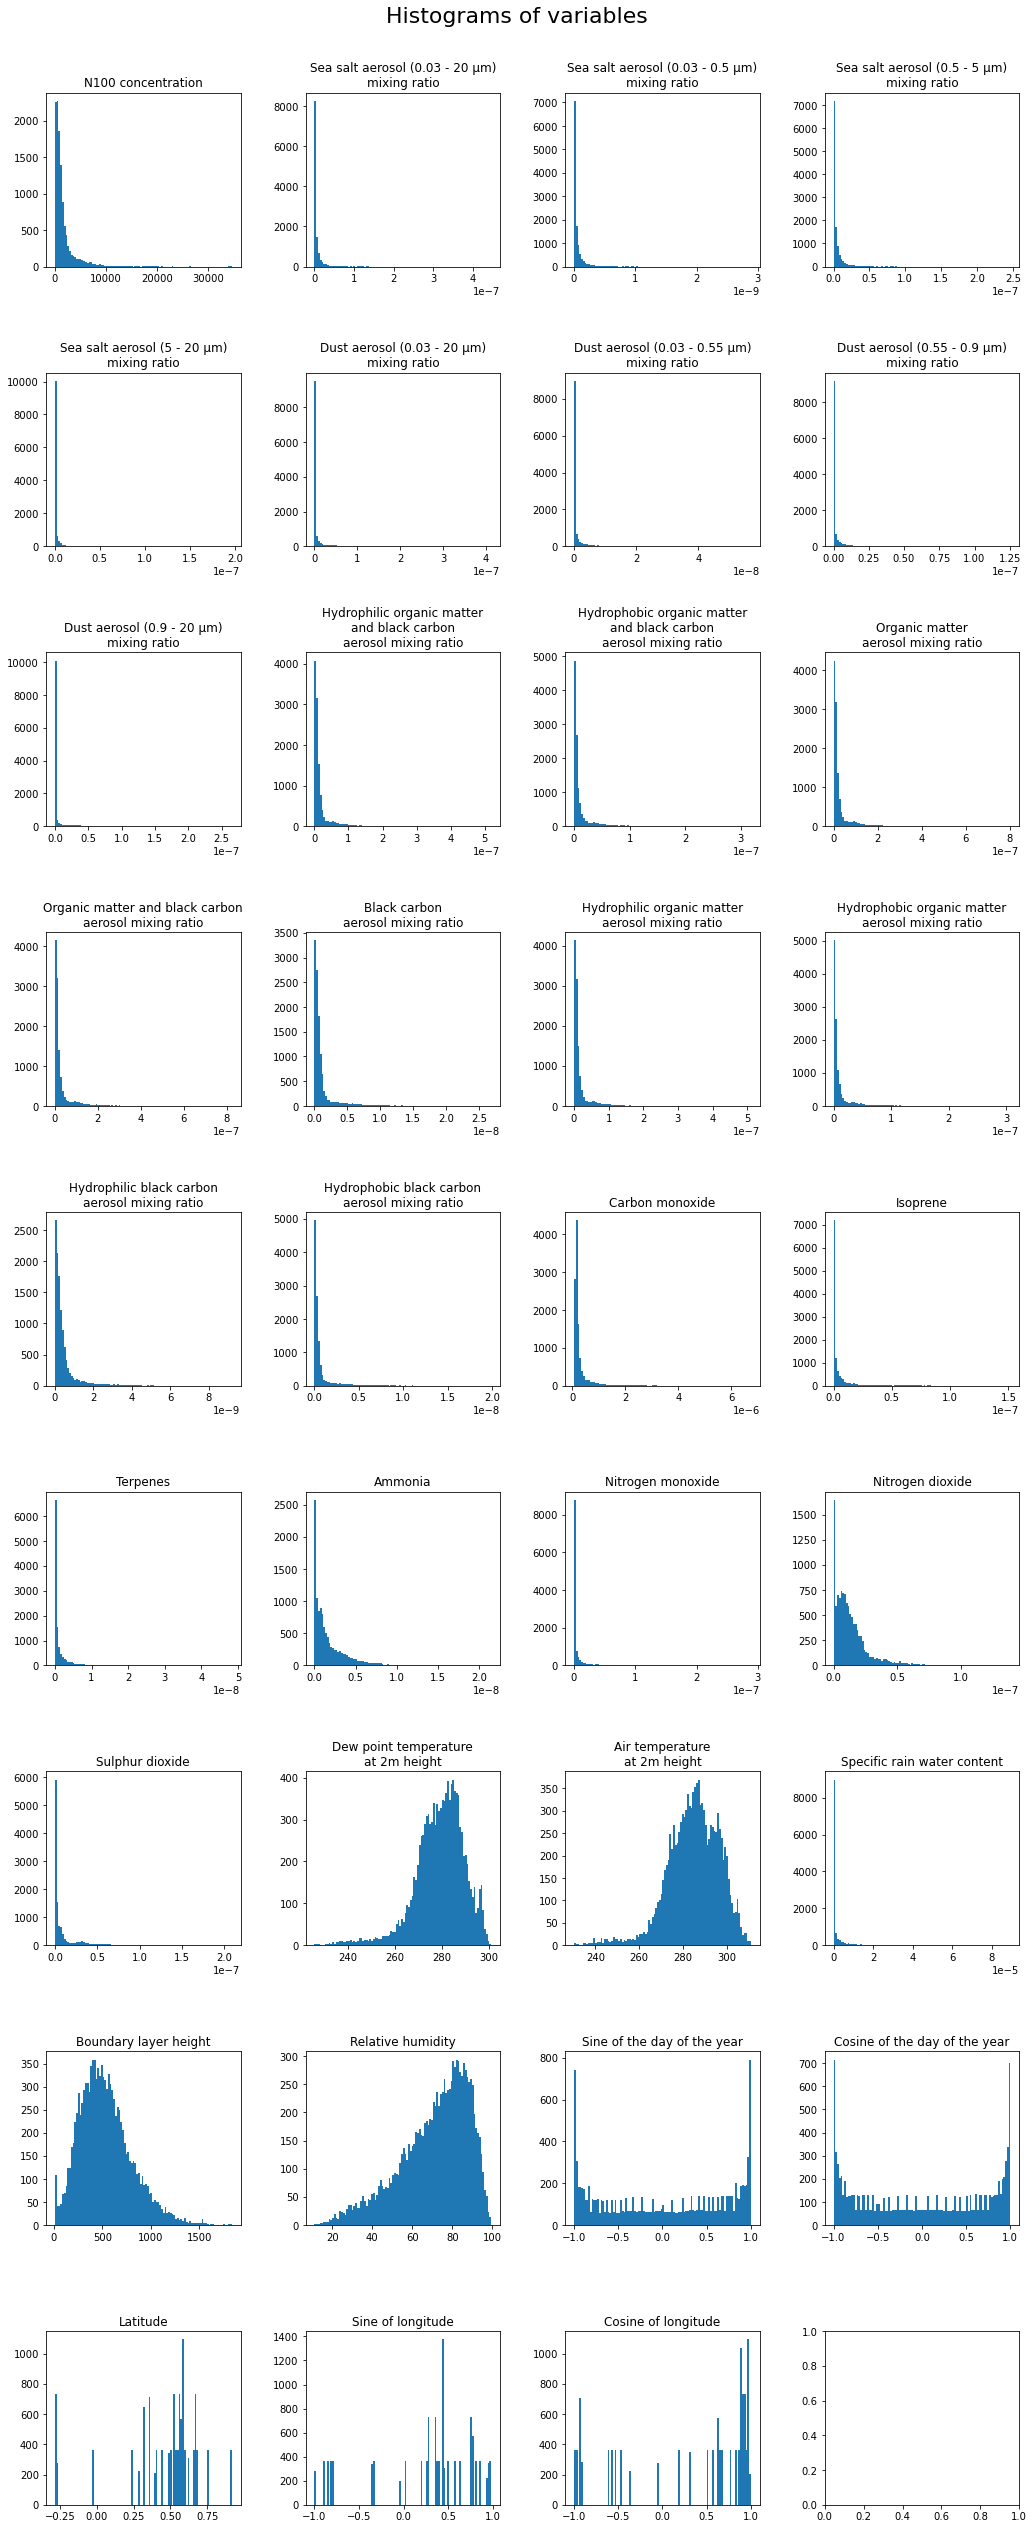

In [46]:
ncols = 4
fig, axes = plt.subplots(9, ncols, figsize=(15,35))
axes = iter(axes)
i = 0

for v in ['n100']+variables:
    if i%ncols == 0:
        axis = next(axes)
    ax = axis[i%ncols]
    ax.hist(data[v], bins=100)
    ax.set_title(variable_dict[v])
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('Histograms of variables', y=1.01, fontsize=22);

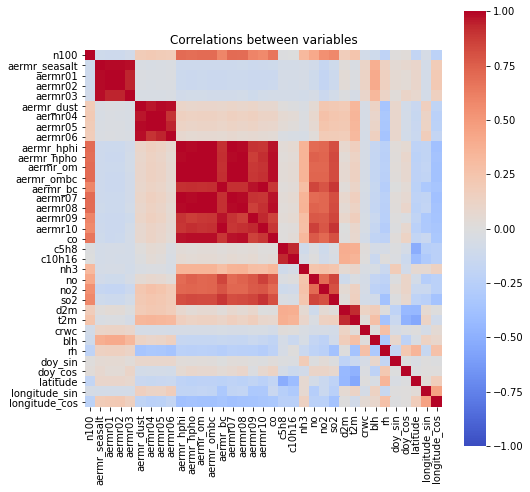

In [47]:
plt.figure(figsize=(8, 8))
sns.heatmap(data[['n100']+variables].corr(), 
            xticklabels=['n100']+variables, yticklabels=['n100']+variables, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1)
plt.title('Correlations between variables');

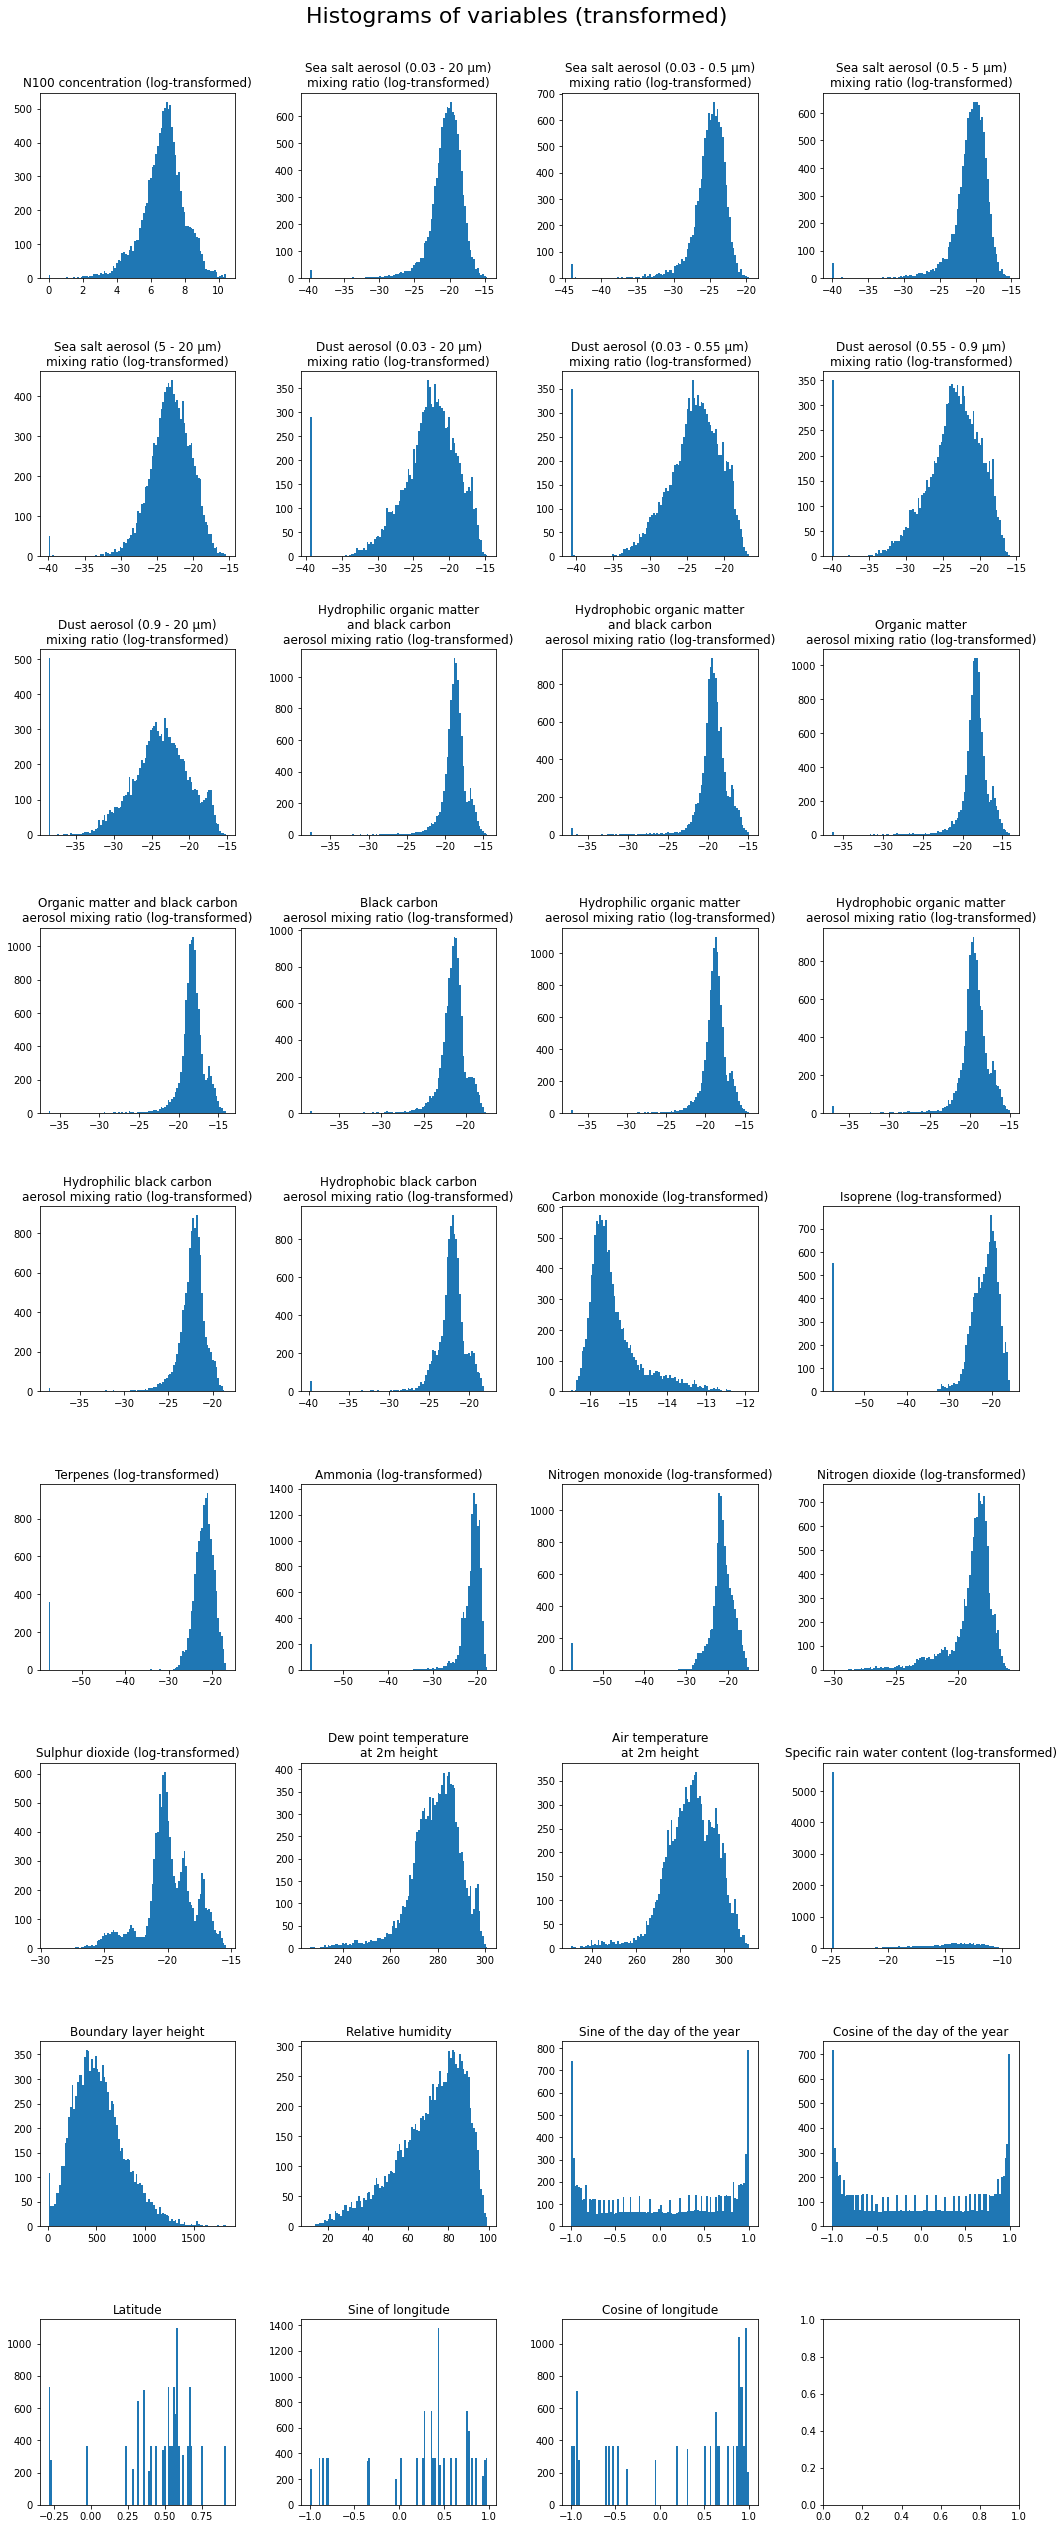

In [48]:
ncols = 4
fig, axes = plt.subplots(9, ncols, figsize=(15,35))
axes = iter(axes)
i = 0

for v in ['n100_log']+transf_vars:
    if i%ncols == 0:
        axis = next(axes)
    ax = axis[i%ncols]
    ax.hist(data[v], bins=100)
    if v[-3:] == 'log':
        ax.set_title(variable_dict[v[:-4]] +' (log-transformed)')
    else:
        ax.set_title(variable_dict[v])
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('Histograms of variables (transformed)', y=1.01, fontsize=22);

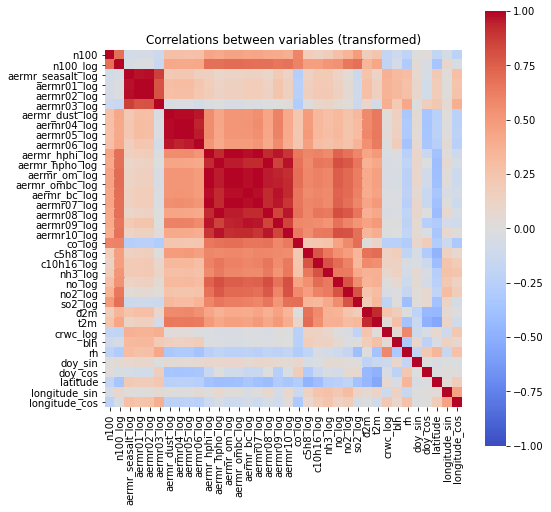

In [49]:
plt.figure(figsize=(8, 8))        
sns.heatmap(data[['n100', 'n100_log']+transf_vars].corr(), 
            xticklabels=['n100', 'n100_log']+transf_vars, yticklabels=['n100', 'n100_log']+transf_vars, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1)
plt.title('Correlations between variables (transformed)');

In [50]:
print('Strongest correlations of variables with N100 (before and after transforming):')

for v in variables:
    corr = np.round(pearsonr(data[v], data.n100), 3)
    extra_space = int(corr[0] >= 0)
    offset = 14 - len(v) + extra_space
    
    if v+'_log' in data.columns:
        transf_corr = np.round(pearsonr(data[v+'_log'], data.n100), 3)
        if np.abs(transf_corr[0]) > np.abs(corr[0]):
            print(v, ' '*offset, corr[0], '\t', ' '*extra_space, transf_corr[0], 
                  ' \tcorr higher with transformed data')
        else:
            print(v, ' '*offset, corr[0], '\t', ' '*extra_space, transf_corr[0])
    else:
        print(v, ' '*offset, corr[0])

Strongest correlations of variables with N100 (before and after transforming):
aermr_seasalt   -0.106 	  -0.079
aermr01         -0.113 	  -0.058
aermr02         -0.114 	  -0.062
aermr03         -0.09 	  -0.127  	corr higher with transformed data
aermr_dust       0.191 	   0.278  	corr higher with transformed data
aermr04          0.203 	   0.276  	corr higher with transformed data
aermr05          0.192 	   0.272  	corr higher with transformed data
aermr06          0.18 	   0.28  	corr higher with transformed data
aermr_hphi       0.707 	   0.44
aermr_hpho       0.695 	   0.415
aermr_om         0.706 	   0.447
aermr_ombc       0.704 	   0.448
aermr_bc         0.591 	   0.431
aermr07          0.708 	   0.441
aermr08          0.698 	   0.414
aermr09          0.599 	   0.413
aermr10          0.574 	   0.388
co               0.661 	   0.599
c5h8            -0.014 	  0.18  	corr higher with transformed data
c10h16          -0.006 	  0.145  	corr higher with transformed data
nh3             

In [51]:
print('Strongest correlations of variables with log-transformed N100 (before and after transforming):')

for v in variables:
    corr = np.round(pearsonr(data[v], data.n100_log), 3)
    extra_space = int(corr[0] >= 0)
    offset = 14 - len(v) + extra_space
    
    if v+'_log' in data.columns:
        transf_corr = np.round(pearsonr(data[v+'_log'], data.n100_log), 3)
        if np.abs(transf_corr[0]) > np.abs(corr[0]):
            print(v, ' '*offset, corr[0], '\t', ' '*extra_space, transf_corr[0], 
                  ' \tcorr higher with transformed data')
        else:
            print(v, ' '*offset, corr[0], '\t', ' '*extra_space, transf_corr[0])
    else:
        print(v, ' '*offset, corr[0])

Strongest correlations of variables with log-transformed N100 (before and after transforming):
aermr_seasalt   -0.213 	  -0.051
aermr01         -0.215 	  -0.023
aermr02         -0.217 	  -0.022
aermr03         -0.2 	  -0.144
aermr_dust       0.235 	   0.426  	corr higher with transformed data
aermr04          0.24 	   0.42  	corr higher with transformed data
aermr05          0.233 	   0.419  	corr higher with transformed data
aermr06          0.225 	   0.429  	corr higher with transformed data
aermr_hphi       0.511 	   0.684  	corr higher with transformed data
aermr_hpho       0.497 	   0.682  	corr higher with transformed data
aermr_om         0.505 	   0.696  	corr higher with transformed data
aermr_ombc       0.507 	   0.697  	corr higher with transformed data
aermr_bc         0.505 	   0.692  	corr higher with transformed data
aermr07          0.51 	   0.686  	corr higher with transformed data
aermr08          0.495 	   0.681  	corr higher with transformed data
aermr09          0.